### Sample code for Comparing NILM algorithms

In [3]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

rcParams['figure.figsize'] = (13, 6)

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, FHMM, MLE

### Dividing data into train and test set

In [4]:
train = DataSet('/home/shifona/Downloads/mini_project/REDD/redd.h5')
test = DataSet('/home/shifona/Downloads/mini_project/REDD/redd.h5')

Let us use building 1 for demo purposes

In [5]:
building = 2

Let's split data at April 30th

In [6]:
train.set_window(end="30-4-2011")
test.set_window(start="30-4-2011")


train_elec = train.buildings[2].elec
test_elec = test.buildings[2].elec

# Selecting top-1 appliances

In [7]:
top_5_train_elec = train_elec.submeters().select_top_k(k=1)

9/9 ElecMeter(instance=11, building=2, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])

### Training and disaggregation

In [8]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}

    for i, chunk in enumerate(test_elec.mains().load(sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = meter.load(sample_period=sample_period).next()
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in gt[i].iteritems()}, index=gt[i].values()[0].index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.ix[common_index_local]
    pred_overall = pred_overall.ix[common_index_local]
    appliance_labels = [m.label() for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [9]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.iteritems():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    clf.train(top_5_train_elec, sample_period=sample_period)
    gt, predictions[clf_name] = predict(clf, test_elec, 120, train.metadata['timezone'])
   
    

********************
FHMM
********************
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
********************
CO
********************
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Done training!
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'


In [10]:
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)
def compute_acc(gt, pred):
    import math
    pd_ = {}
    gt_ = {}
    rerror = {}
    lt = 0
    leng = {}
    napp = []
    for appliance in gt.columns:
        t = len(pred[appliance])
        if lt<t:
            lt = t
            napp = []
        if lt==t:
            napp.append(appliance)
        leng[appliance]= t
        #print(str(appliance) + " : "+str(t))


    for appliance in napp:
        if (leng[appliance] < lt):
            continue
        #print(appliance)
        gt_[appliance] = gt[appliance]
        pd_[appliance] = pred[appliance]
        #print(str(len(pd_[appliance]))+", "+str(len(gt_[appliance])))
    
    #print(napp)
    #print(lt)
    s = 0
    sd = 0
    for i in range(lt):
        for appliance in napp:
            #if isinstance( pd[appliance][0], ( int, long ) ):
            #print( pd_[appliance] )
            #print(i)
            s = s + abs(pd_[appliance][i]-gt_[appliance][i])
            sd = sd + gt_[appliance][i]

    acc_ = 1 - (1.0*s)/sd/2
    #print(acc)
    #print(pd)
    return acc_
    #return pd.Series(rms_error)

In [11]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = compute_rmse(gt, predictions[clf_name])
rmse = pd.DataFrame(rmse)

In [12]:
rmse

,CO,FHMM
Fridge,125.746269,63.316422


In [13]:
accu = {}
for clf_name in classifiers.keys():
    accu[clf_name] = compute_acc(gt, predictions[clf_name])
print(accu)

{'FHMM': 0.82454534890477027, 'CO': 0.63639169717041422}


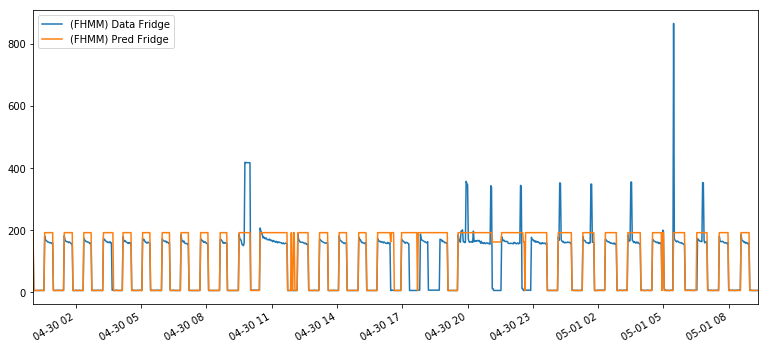

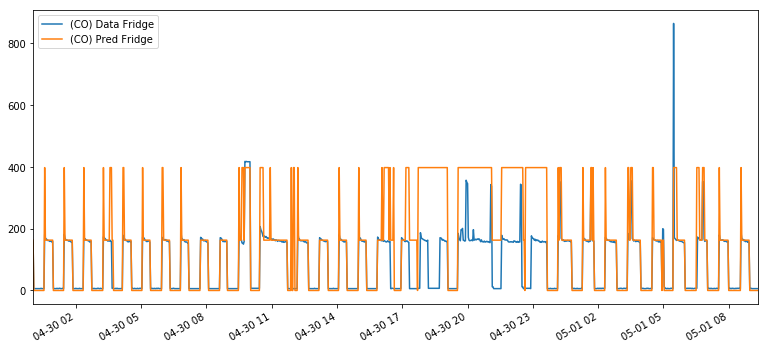

In [14]:
i=0
for clf_name in classifiers.keys():
    pd=predictions[clf_name]
    for app in gt.columns:
        plt.figure(i)
        i=i+1
        gt[app].head(1000).plot(label="("+clf_name+") Data "+str(app))
        pd[app].head(1000).plot(label="("+clf_name+") Pred "+str(app))
        plt.legend()